In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GibsonPrediction.clustering import read_starcode_results, cluster_counter_to_count_df
from GibsonPrediction.utils import contains_RE_site, get_fold_change

The reads from the assembled library were appended to the reads from the input library before clustering. I want to separate them back into input vs assembled, so I need to determine how many reads were in the input library. I'll read in the reads from the input and make sure they're all length 30 before counting how many there are.

In [2]:
with open('../data/starcode_counts/GP_PCR_2_trimmed.txt', 'r') as f:
  input_reads = [line.rstrip() for line in f]

print(sum([len(read) != 30 for read in input_reads]))
print(len(input_reads))

total_reads_input = len(input_reads)

0
12436507


Read in clusters from starcode output, as well as the input file so that individual cluster IDs can be mapped back to their original sequences.

In [3]:
clustered_path = '../data/starcode_counts/PCR_large_rep1_clustered_d5.txt'
unclustered_path = '../data/starcode_counts/PCR_large_rep1.txt'

In [4]:
cluster_counts_input, cluster_counts_assembled = read_starcode_results(clustered_path, unclustered_path, input_count=total_reads_input)

In [5]:
count_df = cluster_counter_to_count_df(cluster_counts_input, cluster_counts_assembled)
count_df.head()

,sequence,input_count,assembled_count
0,AACCTCCTGGAAGGGCAGGCTAAATAAATG,10,13
1,GGACTGGATCCCCAAGTCCGCTGACCCGTT,5,3
2,GCGAGCCGGGGATTTCTGTTCCTGAGTGGT,28,28
3,CCACAGGTATTTCACATCGGTTTTATAGTA,11,3
4,TTGCTATGTAACGAGGGTTGGCTTAAGTAG,23,17


In [6]:
del cluster_counts_input, cluster_counts_assembled

Look at cluster stats.

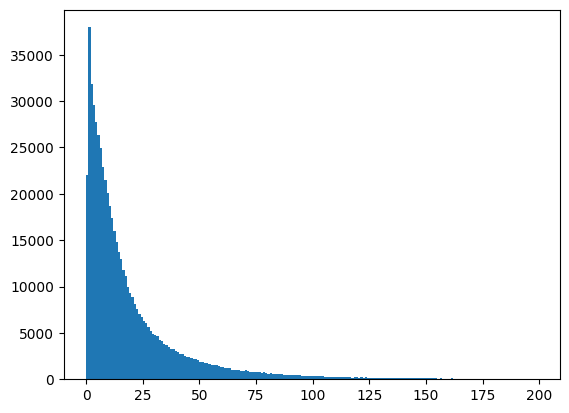

Median count: 11.0
count    589715.000000
mean         21.089012
std          32.506405
min           0.000000
25%           4.000000
50%          11.000000
75%          25.000000
max         994.000000
Name: input_count, dtype: float64


In [7]:
plt.hist(count_df['input_count'], bins=range(200))
plt.show()
print(f"Median count: {count_df['input_count'].median()}")
print(count_df['input_count'].describe())


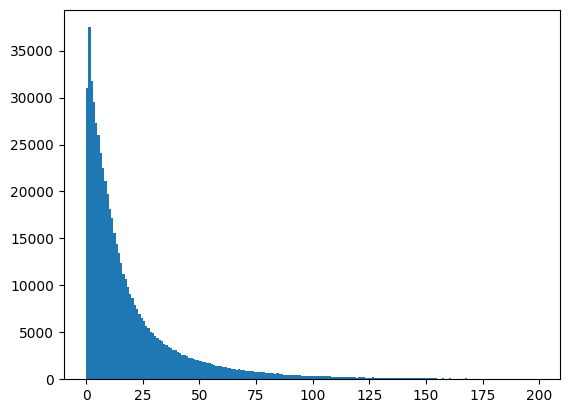

Median count: 11.0
count    589715.000000
mean         20.918088
std          32.236335
min           0.000000
25%           4.000000
50%          11.000000
75%          25.000000
max        1005.000000
Name: assembled_count, dtype: float64


In [8]:
plt.hist(count_df['assembled_count'], bins=range(200))
plt.show()
print(f"Median count: {count_df['assembled_count'].median()}")
print(count_df['assembled_count'].describe())

See if any sequences have input count of 0 before calculating fold change

In [9]:
count_df[count_df['input_count'] == 0].sort_values('assembled_count', ascending=False)

,sequence,input_count,assembled_count
156915,GCGGGACCTACGAAAACTGGGCCCACCGGC,0,18
54572,ATAGAGTCGAGAAGGTGCGTCTTCGTTCTT,0,16
496831,ACGCATCCGAGTCGAAACATGGTGCACTGA,0,15
423667,CACGTTAATTGAGTACGGAGATCGCCATCG,0,15
283665,CCTGGACGGGAAGGGGGGGGAAAAGTCAAT,0,14
...,...,...,...
148323,GGAGCTTAAAAGAATCATACCCGTTCTGCC,0,1
148287,ACCAGACTGGGGCTTTCGTTATTGATTGTT,0,1
359422,GGAGTTGCAATGTACCAACCGATAGGCATG,0,1
359431,GGCCGCGGATACGATCAGACATGTCAAACC,0,1


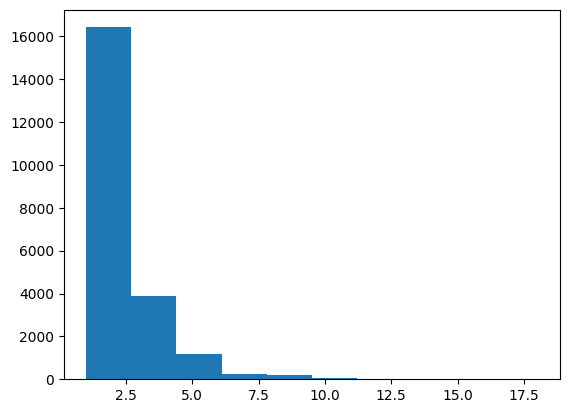

In [10]:
plt.hist(count_df[count_df['input_count'] == 0]['assembled_count'])
plt.show()

Look at distribution of ratio between assembled and input counts for each cluster.

In [11]:
count_df['fold_change'] = get_fold_change(count_df, 1, 1)
count_df['log2_FC'] = np.log2(count_df['fold_change'])
count_df.head()

,sequence,input_count,assembled_count,fold_change,log2_FC
0,AACCTCCTGGAAGGGCAGGCTAAATAAATG,10,13,1.283127,0.359664
1,GGACTGGATCCCCAAGTCCGCTGACCCGTT,5,3,0.672114,-0.573222
2,GCGAGCCGGGGATTTCTGTTCCTGAGTGGT,28,28,1.008171,0.011741
3,CCACAGGTATTTCACATCGGTTTTATAGTA,11,3,0.336057,-1.573222
4,TTGCTATGTAACGAGGGTTGGCTTAAGTAG,23,17,0.756128,-0.403297


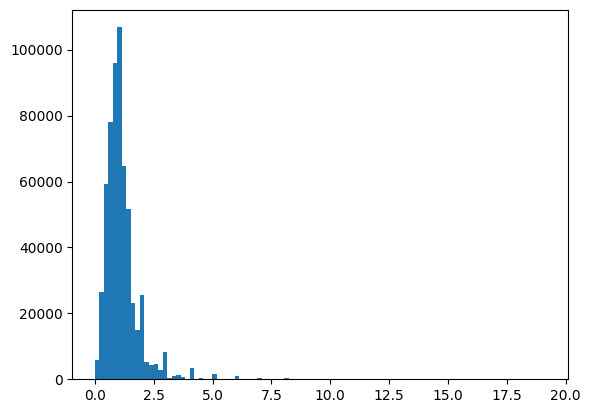

In [12]:
plt.hist(count_df['fold_change'], bins=100)
plt.show()

Look at stats for log fold change

count    589715.000000
mean         -0.041053
std           0.849676
min          -8.993884
25%          -0.473686
50%           0.011741
75%           0.426778
max           4.259668
Name: log2_FC, dtype: float64


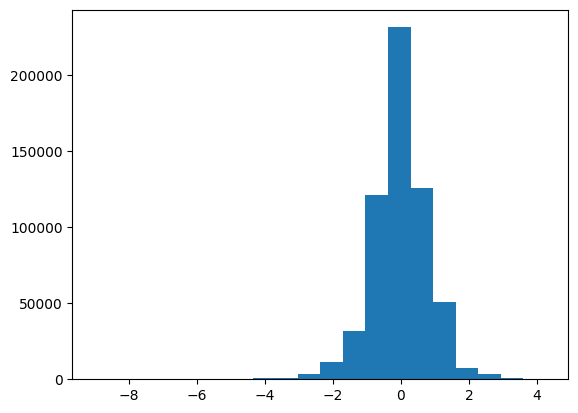

In [13]:
print(count_df['log2_FC'].describe())
plt.hist(count_df['log2_FC'], bins=20)
plt.show()

Look at best and worst sequences for Gibson assembly

In [14]:
count_df[(count_df['input_count'] > 100) & (count_df['assembled_count'] < 20)].sort_values('log2_FC')

,sequence,input_count,assembled_count,fold_change,log2_FC
186881,TAGAAGCCGTCCGTGGGAGTCCTGATACAG,513,0,0.001961,-8.993884
362322,GATGGGCTATAGTGCTCTTCAAGTGCAGTG,410,0,0.002453,-8.671254
201712,TTCCAAGGGAGCGTTTCGGGGTCATCTTAG,377,0,0.002667,-8.550502
254607,GGGTGGTCTGCAGAGATGCGGTCCGTATCA,376,0,0.002674,-8.546680
474054,GGCAAGTAGGTGGCTGCGATTAGTTGACGG,316,0,0.003180,-8.296598
...,...,...,...,...,...
147523,TTGAGTCCATGCGCGGGGCGTGGTTTTTTC,140,18,0.135853,-2.879883
155687,CATGAGTGTGGTCAGTGGCCAGGATGGGCA,109,15,0.146643,-2.769619
376626,AGGAGGTCGTTGCTCTTCATGCAGTTGCCA,127,19,0.157527,-2.666331
192782,GGAAGCATTTCGGGGAAGAGCGGGATTAGT,121,19,0.165274,-2.597069


In [15]:
count_df[(count_df['input_count'] > 20)].sort_values('log2_FC', ascending=False)

,sequence,input_count,assembled_count,fold_change,log2_FC
223026,AGGGTACCGCGCATGAAATCAGCCAGCTCG,21,61,2.841210,1.506505
159660,CATACACGAAACTTGGCCCGGCAAGGTCAT,21,60,2.795384,1.483046
127700,TTTTGCTTGTACTCATCTCAGCGTGGTCGC,28,79,2.781162,1.475688
505227,GCCTTAAAGGGGTACGGAGAGTGGGGACCA,22,60,2.673845,1.418916
520750,TGGAGATTTCCGTAGGCAGGCGTAGATATA,21,57,2.657906,1.410290
...,...,...,...,...,...
474054,GGCAAGTAGGTGGCTGCGATTAGTTGACGG,316,0,0.003180,-8.296598
254607,GGGTGGTCTGCAGAGATGCGGTCCGTATCA,376,0,0.002674,-8.546680
201712,TTCCAAGGGAGCGTTTCGGGGTCATCTTAG,377,0,0.002667,-8.550502
362322,GATGGGCTATAGTGCTCTTCAAGTGCAGTG,410,0,0.002453,-8.671254


Remove sequences that contain a BspQI site and look at worst sequences again.


In [16]:
mask = count_df['sequence'].apply(lambda x: contains_RE_site(x, 'GCTCTTC'))
count_df[mask].sort_values('input_count', ascending=False).head()
# count_df[mask].sort_values('input_count', ascending=False).to_csv('cut.csv', sep='\t')

,sequence,input_count,assembled_count,fold_change,log2_FC
362322,GATGGGCTATAGTGCTCTTCAAGTGCAGTG,410,0,0.002453,-8.671254
195256,GGTAGCTTTGGGATGCGGCGAAGAGCTCCA,283,245,0.873275,-0.195492
474784,GCCCTAGAGGTAAGGAAGAGCTTTAACGTT,243,5,0.024791,-5.334034
494337,GCTCTTCCGGGTGGCGGACAATGGCGCTTT,206,219,1.071486,0.099613
400056,TCCCCCGGCTTTTGGGCTCTTCTTGGCAGG,193,1,0.010394,-6.588172


In [17]:
count_df_no_cut = count_df[~mask]
count_df_no_cut[(count_df_no_cut['input_count'] > 100) & (count_df_no_cut['assembled_count'] < 20)].sort_values('log2_FC')

,sequence,input_count,assembled_count,fold_change,log2_FC
186881,TAGAAGCCGTCCGTGGGAGTCCTGATACAG,513,0,0.001961,-8.993884
201712,TTCCAAGGGAGCGTTTCGGGGTCATCTTAG,377,0,0.002667,-8.550502
254607,GGGTGGTCTGCAGAGATGCGGTCCGTATCA,376,0,0.002674,-8.546680
474054,GGCAAGTAGGTGGCTGCGATTAGTTGACGG,316,0,0.003180,-8.296598
351187,AGCGTGGGCGCACGCCAGTCTTTAGGCGTT,304,0,0.003305,-8.240925
...,...,...,...,...,...
266944,CTTCGGGAGTGTCAGTCAATGAATACGGAT,119,13,0.117620,-3.087795
490651,GTCTTCCCGATGCTTGGTGGCCTATCGCGC,104,13,0.134423,-2.895150
147523,TTGAGTCCATGCGCGGGGCGTGGTTTTTTC,140,18,0.135853,-2.879883
155687,CATGAGTGTGGTCAGTGGCCAGGATGGGCA,109,15,0.146643,-2.769619
